In [312]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [313]:
datos = loadmat('pruebaVictor.mat')

In [314]:
datos['Fv']

array([[250.  ],
       [250.01],
       [250.02],
       ...,
       [329.98],
       [329.99],
       [330.  ]], shape=(8001, 1))

In [315]:
signal = datos['H']

In [316]:
#phi = np.load('basis_functions_complete_space.npz')['x']

In [317]:
phi = np.load('H_distance_8001.npz')['x']

In [318]:
def scalar_product(h1, h2):

    return np.sum(np.conj(h1)*(h2))

def module(h):

    return np.sqrt(scalar_product(h, h))

In [319]:
freqs_ghz = datos['Fv']

In [320]:
Xf = signal

In [321]:
freqs_ghz = freqs_ghz.ravel()      # --> (8001,)
Xf = Xf.ravel() 
# Pasamos a Hz
freqs_hz = freqs_ghz * 1e9

N = len(freqs_hz)

# Resolución en frecuencia
df = freqs_hz[1] - freqs_hz[0]    # ~ 10e6 Hz

# Ventana temporal equivalente (aprox): T = 1/df
T = 1.0 / df
dt = T / N
t = np.arange(N) * dt             # eje temporal (s)

# 1) Señal en *banda base* (envolvente compleja) vía IFFT
# Escalado sencillo: la IFFT asume sum_k X[k] e^{j2π kn/N} / N
# Nosotros queremos algo proporcional a sum_k Xf[k] e^{j2π f_k t_n} df
# Para muchos usos prácticos, basta:
x_bb = np.fft.ifft(Xf)           # envolvente compleja (banda base)

# 2) Si quieres la señal *banda pasante* centrada en 250 GHz:
f0 = freqs_hz[0]                 # 250 GHz en Hz
x_bp = x_bb * np.exp(1j * 2 * np.pi * f0 * t)

In [322]:
Q_bb_alt = []
for phi_ in phi:
    Q_bb_alt.append(scalar_product(phi_, x_bb))

In [414]:
Q_bb_alt_filt = keep_n_largest_components(Q_bb_alt, 10)

In [539]:
recovered_bb_alt = np.array(Q_bb_alt)@phi

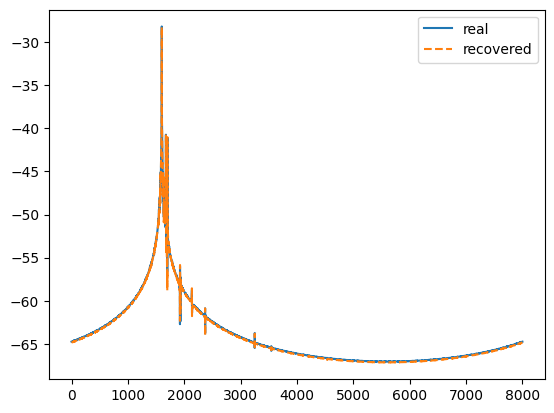

In [540]:
plt.plot(10*np.log10(np.abs(x_bb)), label='real')
plt.plot(10*np.log10(np.abs(recovered_bb_alt)), label='recovered', linestyle='--')

plt.legend()

In [325]:
Phi = np.column_stack(phi)          # (8001, 8001) si tienes 8001 vectores
c = np.linalg.solve(Phi.conj().T @ Phi, Phi.conj().T @ x_bb)
x_hat = Phi @ c


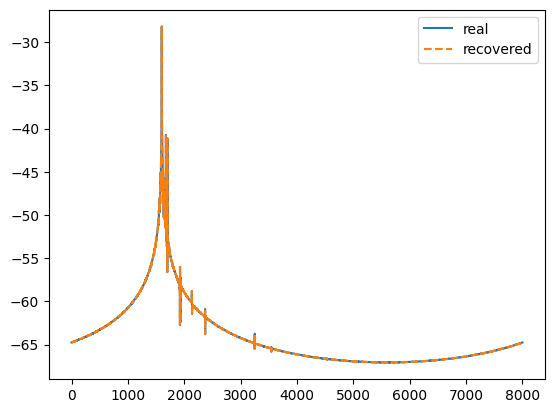

In [326]:
plt.plot(10*np.log10(np.abs(x_bb)), label='real')
plt.plot(10*np.log10(np.abs(x_hat)), label='recovered', linestyle='--')

plt.legend()

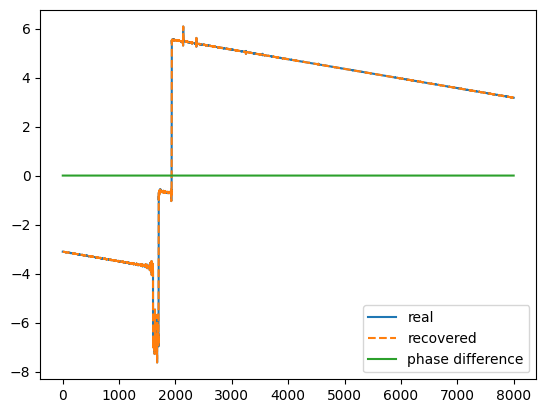

In [343]:
plt.plot((np.unwrap(np.angle(x_bb))), label='real')
plt.plot(np.unwrap(np.angle(x_hat)), label='recovered', linestyle='--')
plt.plot(np.unwrap(np.angle(x_hat)) - (np.unwrap(np.angle(x_bb))), label='phase difference')
plt.legend()

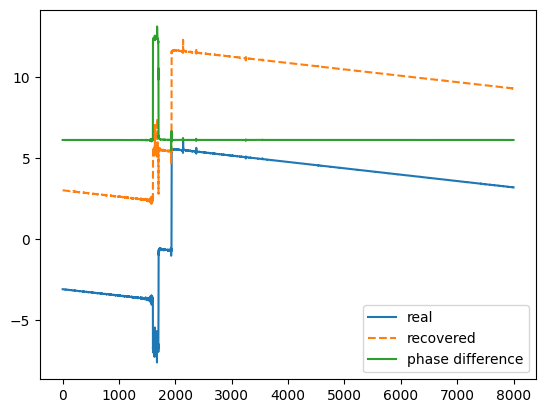

In [327]:
plt.plot((np.unwrap(np.angle(x_bb))), label='real')
plt.plot(np.unwrap(np.angle(recovered_bb_alt)), label='recovered', linestyle='--')
plt.plot(np.unwrap(np.angle(recovered_bb_alt)) - (np.unwrap(np.angle(x_bb))), label='phase difference')
plt.legend()

### Actual measurements

In [328]:
measurements = loadmat('pruebaVictor-1.mat')

In [329]:
def normalize_vectors(X):
    """
    X: matriz 2D (num_vectors, vector_length)
       con componentes complejas.
    
    Devuelve una matriz del mismo tamaño con cada vector normalizado
    a norma 1: x / ||x||.
    """
    X = np.asarray(X, dtype=np.complex128)

    # norma de cada vector (fila)
    norms = np.linalg.norm(X, axis=1, keepdims=True)

    # evitar división por cero
    norms[norms == 0] = 1.0

    # normalizar
    return X / norms

In [330]:
meas = measurements['h'].reshape(-1)

In [331]:
Q_meas = []
for phi_ in phi:
    Q_meas.append(scalar_product(phi_, meas))

In [332]:
recovered_meas = np.array(Q_meas)@phi

In [333]:
import numpy as np

def keep_n_largest_components(x, n):
    """
    x: vector 1D
    n: número de componentes a conservar (por valor absoluto)
    """
    x = np.asarray(x)
    y = np.zeros_like(x)

    # índices de los n mayores valores absolutos
    idx = np.argpartition(np.abs(x), -n)[-n:]

    # copiar solo esos valores
    y[idx] = x[idx]
    return y


In [527]:
Q_meas_filtered = keep_n_largest_components(Q_meas, 800)

In [541]:
recovered_meas_filt = np.array(Q_meas)@phi

C:\Users\LabCETIC\AppData\Local\Temp\ipykernel_13428\491798111.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(np.abs(meas)), label='real')


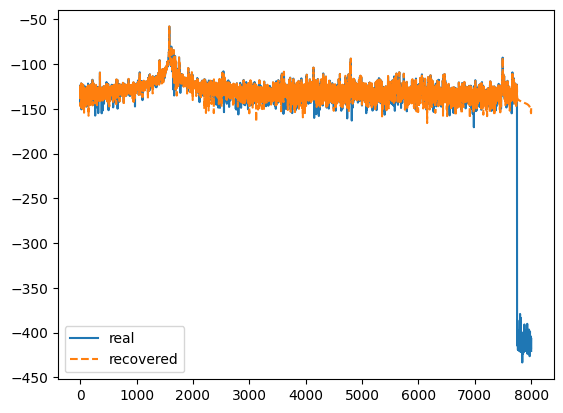

In [542]:
plt.plot(20*np.log10(np.abs(meas)), label='real')
plt.plot(20*np.log10(np.abs(recovered_meas_filt)), label='recovered', linestyle='--')

plt.legend()

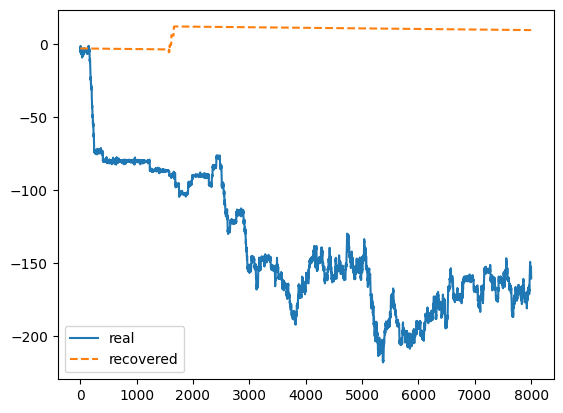

In [471]:
plt.plot((np.unwrap(np.angle(meas))), label='real')
plt.plot((np.unwrap(np.angle(recovered_meas_filt))), label='recovered', linestyle='--')

plt.legend()

## Resolviendo la expansión por mínimos cuadrados

In [338]:
c_meas = np.linalg.solve(Phi.conj().T @ Phi, Phi.conj().T @ meas)
x_hat_meas = Phi @ c_meas

In [549]:
c_meas_filtered = keep_n_largest_components(c_meas, 100)

In [550]:
x_hat_meas_filt = Phi @ c_meas_filtered

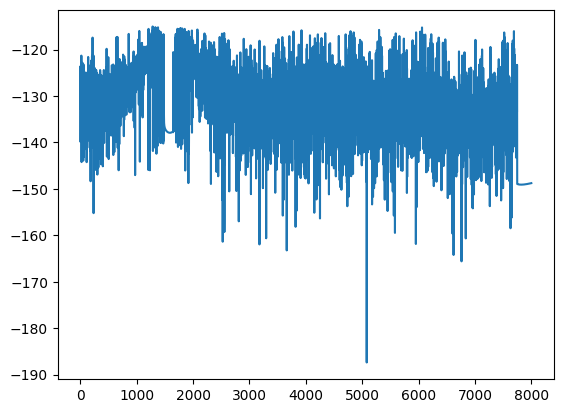

In [535]:
plt.plot(20*np.log10(np.abs(meas-x_hat_meas_filt)))

In [536]:
from scipy.stats import gaussian_kde
import numpy as np

re = np.real(meas-x_hat_meas_filt)   # tus muestras
im = np.imag(meas-x_hat_meas_filt)

data = re 

kde_r = gaussian_kde(data)     # por defecto kernel gaussiano
x_r = np.linspace(data.min(), data.max(), 1000)
pdf_r = kde_r(x_r)


In [537]:
data = im
kde_i = gaussian_kde(data)     # por defecto kernel gaussiano
x_i = np.linspace(data.min(), data.max(), 1000)
pdf_i = kde_i(x_i)

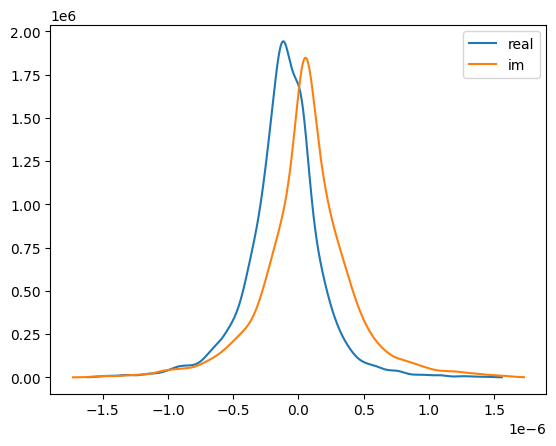

In [538]:
plt.plot(x_r, pdf_r, label='real')
plt.plot(x_i, pdf_i, label='im')
plt.legend()


C:\Users\LabCETIC\AppData\Local\Temp\ipykernel_13428\3156066517.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(np.abs(meas)), label='real')


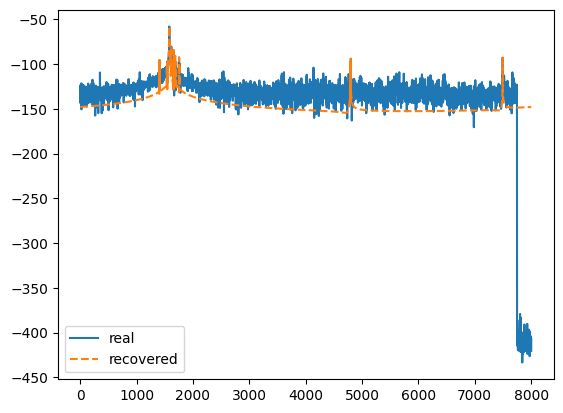

In [555]:
plt.plot(20*np.log10(np.abs(meas)), label='real')
plt.plot(20*np.log10(np.abs(x_hat_meas_filt)), label='recovered', linestyle='--')
#plt.xlim(900, 2000)
plt.legend()

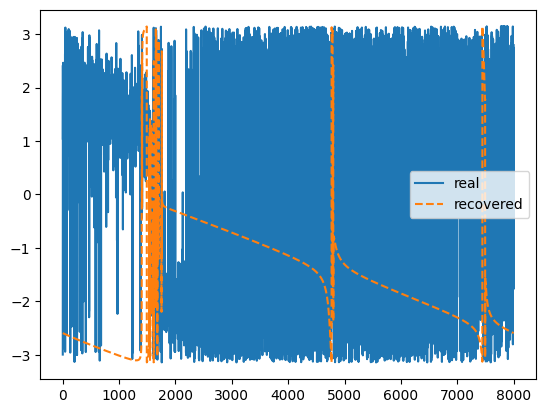

In [552]:
plt.plot(((np.angle(meas))), label='real')
plt.plot(((np.angle(x_hat_meas_filt))), label='recovered', linestyle='--')

plt.legend()

In [553]:
Xf = np.fft.fft(x_hat_meas_filt)
Xbb = np.fft.fft(meas)

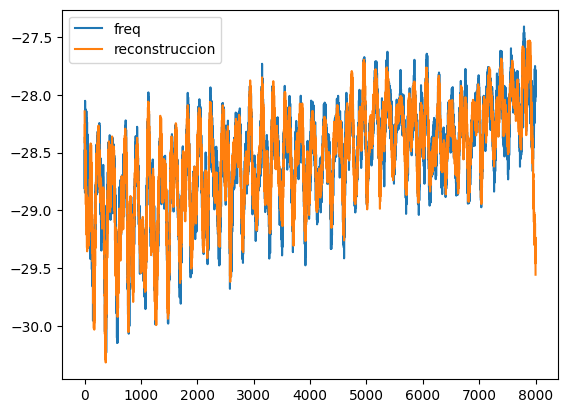

In [554]:
plt.plot(10*np.log10(np.abs(Xbb)), label='freq')
plt.plot(10*np.log10(np.abs(Xf)), label='reconstruccion')
plt.legend()

In [483]:
err_rel_freq = np.abs((10*np.log10(np.abs(Xbb)) - 10*np.log10(np.abs(Xf)))/(10*np.log10(np.abs(Xbb))))

In [484]:
np.sum(err_rel_freq)

np.float64(56.88249447321694)

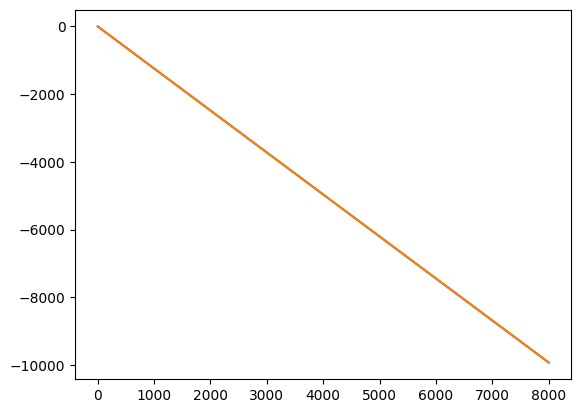

In [405]:
plt.plot(np.unwrap(np.angle(Xf)), label='freq')
plt.plot(np.unwrap(np.angle(Xbb)), label='freq')

## Prueba gráfica con error

In [431]:
err_rel = []
for i in range(1001):
    print(i)
    c_meas_filtered = keep_n_largest_components(c_meas, i)
    x_hat_meas_filt = Phi @ c_meas_filtered
    Xf = np.fft.fft(x_hat_meas_filt)
    err_rel.append(np.sum(np.abs((10*np.log10(np.abs(Xbb)) - 10*np.log10(np.abs(Xf)))/(10*np.log10(np.abs(Xbb))))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [497]:
import numpy as np

err_rel = np.asarray(err_rel)

diff_rel = 100*(err_rel[1:] - err_rel[:-1]) / err_rel[:-1]


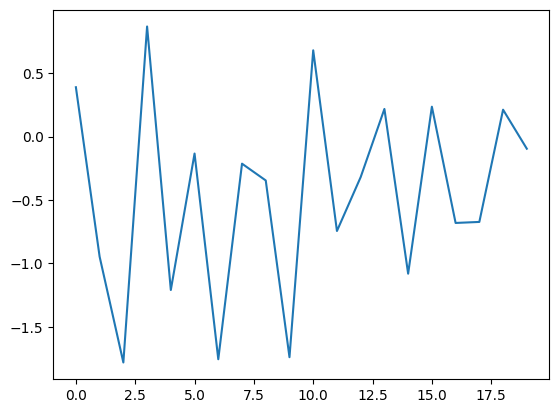

In [499]:
plt.plot(diff_rel[80:100])